# V2 Shallow-Wide Model Analysis

Comprehensive analysis of the 22 V2 models trained with shallow-wide architectures.

## Analysis Overview
1. **Model Inventory** - Load all V2 models and compare with V1 baselines
2. **Accuracy Analysis** - Validation loss, position/slope errors
3. **Timing Benchmarks** - Inference speed comparison
4. **Architecture Comparison** - Width vs depth tradeoffs
5. **Physics Validation** - Momentum-dependent performance, charge asymmetry
6. **Best Model Selection** - Pareto frontier of accuracy vs speed

In [8]:
# Imports and Setup
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Project paths
PROJECT_ROOT = Path('/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation')
MODELS_DIR = PROJECT_ROOT / 'trained_models'
DATA_DIR = PROJECT_ROOT / 'data_generation' / 'data'
PLOTS_DIR = PROJECT_ROOT / 'analysis' / 'plots'
RESULTS_DIR = PROJECT_ROOT / 'results'

# Add models to path
sys.path.insert(0, str(PROJECT_ROOT / 'models'))
from architectures import create_model, MLP, PINN, RK_PINN

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")

# Reference C++ timing
CPP_RK4_TIME_US = 2.50  # μs/track (from benchmark_summary.csv)

Device: cpu
PyTorch: 2.9.1+cu128


## 1. Model Inventory

In [9]:
def load_model_info(model_dir):
    """Load model configuration and training info."""
    info = {'name': model_dir.name, 'path': model_dir}
    
    # Load config
    config_path = model_dir / 'config.json'
    if config_path.exists():
        with open(config_path) as f:
            config = json.load(f)
        info['model_type'] = config.get('model_type', 'unknown')
        info['hidden_dims'] = config.get('hidden_dims', [])
        info['parameters'] = config.get('parameters', 0)
        info['activation'] = config.get('activation', 'silu')
        info['n_layers'] = len(config.get('hidden_dims', []))
        info['max_width'] = max(config.get('hidden_dims', [0]))
    
    # Load training history
    history_path = model_dir / 'history.json'
    if history_path.exists():
        with open(history_path) as f:
            history = json.load(f)
        info['trained'] = True
        # History format: {'train': [...], 'val': [...]}
        train_hist = history.get('train', [])
        val_hist = history.get('val', [])
        info['epochs'] = len(train_hist)
        if val_hist:
            val_losses = [v.get('loss', float('inf')) for v in val_hist]
            info['best_val_loss'] = min(val_losses) if val_losses else float('inf')
        else:
            info['best_val_loss'] = float('inf')
        if train_hist:
            info['final_train_loss'] = train_hist[-1].get('loss', None)
    else:
        info['trained'] = (model_dir / 'best_model.pt').exists()
        info['epochs'] = 0
        info['best_val_loss'] = None
    
    # Check for best model
    info['has_model'] = (model_dir / 'best_model.pt').exists()
    
    return info

# Load all V2 models
v2_models = []
for model_dir in sorted(MODELS_DIR.glob('*_v2_*')):
    info = load_model_info(model_dir)
    v2_models.append(info)

v2_df = pd.DataFrame(v2_models)
print(f"Found {len(v2_df)} V2 models")
print(f"Trained: {v2_df['has_model'].sum()}")
print(f"With history: {v2_df['epochs'].gt(0).sum()}")
print()

# Display summary
display_cols = ['name', 'model_type', 'hidden_dims', 'parameters', 'n_layers', 'max_width', 'epochs', 'best_val_loss']
v2_df[display_cols].sort_values('best_val_loss')

Found 22 V2 models
Trained: 22
With history: 19



,name,model_type,hidden_dims,parameters,n_layers,max_width,epochs,best_val_loss
4,mlp_v2_shallow_512_256,mlp,"[512, 256]",0,2,512,20,0.000291
3,mlp_v2_shallow_512,mlp,"[512, 512]",0,2,512,20,0.000320
0,mlp_v2_shallow_1024_256,mlp,"[1024, 256]",0,2,1024,20,0.000359
1,mlp_v2_shallow_1024_512,mlp,"[1024, 512]",0,2,1024,20,0.000427
2,mlp_v2_shallow_256,mlp,"[256, 256]",0,2,256,20,0.000861
11,pinn_v2_shallow_512,pinn,"[512, 512]",0,2,512,20,0.001791
12,pinn_v2_shallow_512_256,pinn,"[512, 256]",0,2,512,20,0.001830
17,rkpinn_v2_shallow_256,rk_pinn,"[256, 256]",0,2,256,20,0.001851
19,rkpinn_v2_shallow_512_256,rk_pinn,"[512, 256]",0,2,512,20,0.001852
6,mlp_v2_single_256,mlp,[256],0,1,256,20,0.002227


In [10]:
# Load V1 models for comparison
v1_models = []
for model_dir in sorted(MODELS_DIR.glob('*_v1')):
    if 'v2' not in model_dir.name:
        info = load_model_info(model_dir)
        v1_models.append(info)

v1_df = pd.DataFrame(v1_models)
print(f"Found {len(v1_df)} V1 models for comparison")

# Summary by model type
print("\nV2 Models by Type:")
print(v2_df.groupby('model_type').agg({
    'name': 'count',
    'best_val_loss': ['min', 'mean'],
    'parameters': ['min', 'max']
}).round(6))

Found 24 V1 models for comparison

V2 Models by Type:
            name best_val_loss           parameters    
           count           min      mean        min max
model_type                                             
mlp            8      0.000291  0.001260          0   0
pinn           8      0.001791  0.015581          0   0
rk_pinn        6      0.001851  0.002973          0   0


## 2. Load Test Data

In [14]:
# Load test data
data_path = DATA_DIR / 'training_50M.npz'
print(f"Loading data from {data_path}...")

data = np.load(data_path)
X_full = data['X'].astype(np.float32)  # [N, 6]
Y_full = data['Y'].astype(np.float32)  # [N, 4]
P_full = data['P'].astype(np.float32)

# Use test split (last 10%)
n_test = len(X_full) // 10
X_test = X_full[-n_test:]
Y_test = Y_full[-n_test:]
P_test = P_full[-n_test:]

# Sample for faster analysis
N_SAMPLES = 100000
np.random.seed(42)
idx = np.random.choice(len(X_test), N_SAMPLES, replace=False)
X_test = X_test[idx]
Y_test = Y_test[idx]
P_test = P_test[idx]

# Convert to tensors
X_tensor = torch.from_numpy(X_test).to(device)
Y_tensor = torch.from_numpy(Y_test).to(device)

print(f"Test data: {len(X_test):,} samples")
print(f"Input shape: {X_test.shape}")
print(f"Output shape: {Y_test.shape}")
print(f"Momentum range: {P_test.min():.1f} - {P_test.max():.1f} GeV")

Loading data from /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/data_generation/data/training_50M.npz...
Test data: 100,000 samples
Input shape: (100000, 6)
Output shape: (100000, 4)
Momentum range: 0.5 - 100.0 GeV


## 3. Accuracy Analysis

In [17]:
def load_model(model_dir, device):
    """Load a trained model."""
    config_path = model_dir / 'config.json'
    model_path = model_dir / 'best_model.pt'
    
    if not model_path.exists():
        return None
    
    with open(config_path) as f:
        config = json.load(f)
    
    model_type = config.get('model_type', 'mlp').lower()
    hidden_dims = config.get('hidden_dims', [256, 256])
    
    # Create model - different classes have different signatures
    if model_type == 'mlp':
        model = MLP(input_dim=6, output_dim=4, hidden_dims=hidden_dims)
    elif model_type == 'pinn':
        model = PINN(hidden_dims=hidden_dims)
    elif model_type == 'rk_pinn':
        model = RK_PINN(hidden_dims=hidden_dims)
    else:
        return None
    
    # Load weights
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model = model.to(device)
    model.eval()
    return model

def evaluate_model(model, X, Y_true, batch_size=10000):
    """Evaluate model accuracy."""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            pred = model(batch)
            predictions.append(pred.cpu().numpy())
    
    Y_pred = np.vstack(predictions)
    Y_true_np = Y_true.cpu().numpy() if torch.is_tensor(Y_true) else Y_true
    
    # Calculate errors
    errors = Y_pred - Y_true_np
    
    # Position error (x, y combined)
    pos_error = np.sqrt(errors[:, 0]**2 + errors[:, 1]**2)  # mm
    
    # Slope errors
    tx_error = np.abs(errors[:, 2]) * 1000  # mrad
    ty_error = np.abs(errors[:, 3]) * 1000  # mrad
    slope_error = np.sqrt(errors[:, 2]**2 + errors[:, 3]**2) * 1000  # mrad
    
    return {
        'mse': np.mean(errors**2),
        'pos_mean': np.mean(pos_error),
        'pos_std': np.std(pos_error),
        'pos_90': np.percentile(pos_error, 90),
        'slope_mean': np.mean(slope_error),
        'slope_std': np.std(slope_error),
        'slope_90': np.percentile(slope_error, 90),
        'predictions': Y_pred,
        'errors': errors
    }

In [18]:
# Evaluate all V2 models
results = []

for _, row in tqdm(v2_df.iterrows(), total=len(v2_df), desc="Evaluating models"):
    if not row['has_model']:
        continue
    
    model = load_model(row['path'], device)
    if model is None:
        continue
    
    metrics = evaluate_model(model, X_tensor, Y_tensor)
    
    results.append({
        'name': row['name'],
        'model_type': row['model_type'],
        'hidden_dims': str(row['hidden_dims']),
        'parameters': row['parameters'],
        'n_layers': row['n_layers'],
        'max_width': row['max_width'],
        'val_loss': row['best_val_loss'],
        'mse': metrics['mse'],
        'pos_mean_mm': metrics['pos_mean'],
        'pos_90_mm': metrics['pos_90'],
        'slope_mean_mrad': metrics['slope_mean'],
        'slope_90_mrad': metrics['slope_90'],
    })
    
    # Clean up
    del model
    torch.cuda.empty_cache()

results_df = pd.DataFrame(results)
print(f"\nEvaluated {len(results_df)} models")

Evaluating models: 100%|██████████| 22/22 [00:30<00:00,  1.37s/it]


Evaluated 22 models


In [19]:
# Display results sorted by position error
results_df.sort_values('pos_mean_mm')[[
    'name', 'model_type', 'hidden_dims', 'parameters', 
    'pos_mean_mm', 'pos_90_mm', 'slope_mean_mrad', 'slope_90_mrad'
]].round(4)

,name,model_type,hidden_dims,parameters,pos_mean_mm,pos_90_mm,slope_mean_mrad,slope_90_mrad
4,mlp_v2_shallow_512_256,mlp,"[512, 256]",0,0.028100,0.051300,0.415900,0.767300
3,mlp_v2_shallow_512,mlp,"[512, 512]",0,0.029400,0.053100,0.333300,0.670800
0,mlp_v2_shallow_1024_256,mlp,"[1024, 256]",0,0.030800,0.059500,0.678400,1.376100
1,mlp_v2_shallow_1024_512,mlp,"[1024, 512]",0,0.034200,0.063500,0.782600,1.500700
2,mlp_v2_shallow_256,mlp,"[256, 256]",0,0.044300,0.086800,0.263000,0.486900
5,mlp_v2_single_1024,mlp,[1024],0,0.062000,0.149300,0.026100,0.047500
6,mlp_v2_single_256,mlp,[256],0,0.065200,0.135400,0.016700,0.034500
7,mlp_v2_single_512,mlp,[512],0,0.068000,0.138700,0.012700,0.027700
14,pinn_v2_single_256,pinn,[256],0,664.458191,975.055786,98.882004,141.128693
15,pinn_v2_single_512,pinn,[512],0,779.851379,1146.910278,105.969498,152.945801


In [30]:
# DEBUG: Investigate PINN vs MLP predictions
import torch

# Load one MLP and one PINN model
mlp_dir = MODELS_DIR / 'mlp_v2_shallow_256'
pinn_dir = MODELS_DIR / 'pinn_v2_single_256'

# Load MLP
mlp_model = load_model(mlp_dir, device)
print(f"MLP normalization (col 5): mean={mlp_model.input_mean[5].item():.4f}, std={mlp_model.input_std[5].item():.10f}")

# Load PINN
pinn_model = load_model(pinn_dir, device)
print(f"PINN normalization (col 5): mean={pinn_model.input_mean[5].item():.4f}, std={pinn_model.input_std[5].item():.10f}")

# Test on a single sample
test_sample = X_tensor[:1]
print(f"\nTest input: {test_sample}")
print(f"Test input col 5 (dz): {test_sample[0, 5].item():.1f}")

# MLP prediction
with torch.no_grad():
    mlp_pred = mlp_model(test_sample)
    print(f"\nMLP prediction: {mlp_pred}")

# PINN prediction - let's trace through manually
with torch.no_grad():
    pinn_pred = pinn_model(test_sample)
    print(f"PINN prediction: {pinn_pred}")

# True output
print(f"\nTrue output: {Y_tensor[:1]}")

# Check errors
print(f"\nMLP position error: {torch.sqrt((mlp_pred[0, 0] - Y_tensor[0, 0])**2 + (mlp_pred[0, 1] - Y_tensor[0, 1])**2).item():.4f} mm")
print(f"PINN position error: {torch.sqrt((pinn_pred[0, 0] - Y_tensor[0, 0])**2 + (pinn_pred[0, 1] - Y_tensor[0, 1])**2).item():.4f} mm")

MLP normalization (col 5): mean=8000.0000, std=0.0000000100
PINN normalization (col 5): mean=0.0000, std=1.0000000000

Test input: tensor([[ 1.8700e+02, -6.3802e+01, -5.4790e-02,  3.5479e-02, -3.1632e-05,
          8.0000e+03]])
Test input col 5 (dz): 8000.0

MLP prediction: tensor([[-2.5113e+02,  2.2003e+02, -5.4849e-02,  3.5598e-02]])
PINN prediction: tensor([[-4.3571e+02,  3.8917e+02, -9.8798e-02,  6.7256e-02]])

True output: tensor([[-2.5114e+02,  2.2003e+02, -5.4760e-02,  3.5479e-02]])

MLP position error: 0.0050 mm
PINN position error: 250.3471 mm


In [31]:
# Trace through PINN forward pass step by step
print("=== PINN Forward Pass Trace ===\n")

# Step 1: Get test sample
test_sample = X_tensor[:1].clone()
print(f"1. Input shape: {test_sample.shape}")
print(f"   Input: {test_sample}")
print(f"   Input col 5 (dz): {test_sample[0, 5].item():.1f}")

# Step 2: PINN forward does x_query[:, 5] = 1.0
with torch.no_grad():
    x_query = test_sample.clone()
    print(f"\n2. x_query = test_sample.clone()")
    print(f"   x_query[:, 5] = 1.0")
    x_query[:, 5] = 1.0
    print(f"   x_query: {x_query}")
    
    # Step 3: Normalize input
    print(f"\n3. Normalize input:")
    print(f"   input_mean: {pinn_model.input_mean}")
    print(f"   input_std: {pinn_model.input_std}")
    x_norm = pinn_model.normalize_input(x_query)
    print(f"   x_norm = (x_query - mean) / std")
    print(f"   x_norm: {x_norm}")
    print(f"   x_norm col 5: {x_norm[0, 5].item():.6f} (should be 1.0)")
    
    # Step 4: Through network
    y_norm = pinn_model.network(x_norm)
    print(f"\n4. y_norm from network: {y_norm}")
    
    # Step 5: Denormalize output
    print(f"\n5. Denormalize output:")
    print(f"   output_mean: {pinn_model.output_mean}")
    print(f"   output_std: {pinn_model.output_std}")
    y = pinn_model.denormalize_output(y_norm)
    print(f"   y = y_norm * std + mean")
    print(f"   y (final): {y}")

print(f"\nTrue output: {Y_tensor[:1]}")
print(f"PINN error: {torch.sqrt((y[0, 0] - Y_tensor[0, 0])**2 + (y[0, 1] - Y_tensor[0, 1])**2).item():.4f} mm")

=== PINN Forward Pass Trace ===

1. Input shape: torch.Size([1, 6])
   Input: tensor([[ 1.8700e+02, -6.3802e+01, -5.4790e-02,  3.5479e-02, -3.1632e-05,
          8.0000e+03]])
   Input col 5 (dz): 8000.0

2. x_query = test_sample.clone()
   x_query[:, 5] = 1.0
   x_query: tensor([[ 1.8700e+02, -6.3802e+01, -5.4790e-02,  3.5479e-02, -3.1632e-05,
          1.0000e+00]])

3. Normalize input:
   input_mean: tensor([-2.1186e-02, -2.6615e-02, -1.2236e-05, -1.4929e-06, -3.7862e-08,
         0.0000e+00])
   input_std: tensor([1.7320e+02, 1.4433e+02, 8.6604e-02, 8.6608e-02, 6.1448e-04, 1.0000e+00])
   x_norm = (x_query - mean) / std
   x_norm: tensor([[ 1.0798, -0.4419, -0.6325,  0.4097, -0.0514,  1.0000]])
   x_norm col 5: 1.000000 (should be 1.0)

4. y_norm from network: tensor([[-0.6099,  0.5499, -1.1406,  0.7766]])

5. Denormalize output:
   output_mean: tensor([-1.1885e-01, -3.8544e-02, -1.2201e-05, -1.4906e-06])
   output_std: tensor([7.1416e+02, 7.0772e+02, 8.6606e-02, 8.6609e-02])
   y 

## 4. Timing Benchmarks

In [20]:
def benchmark_inference(model, X, n_warmup=10, n_runs=100):
    """Benchmark model inference time."""
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(X)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Timed runs
    times = []
    with torch.no_grad():
        for _ in range(n_runs):
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(X)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            times.append(time.perf_counter() - start)
    
    total_time = np.mean(times)
    time_per_track = total_time / len(X) * 1e6  # μs
    
    return {
        'total_ms': total_time * 1000,
        'per_track_us': time_per_track,
        'throughput': len(X) / total_time,
        'std_us': np.std(times) / len(X) * 1e6
    }

# Benchmark all models
timing_results = []

# Use smaller batch for timing
X_timing = X_tensor[:10000]

for _, row in tqdm(v2_df.iterrows(), total=len(v2_df), desc="Timing models"):
    if not row['has_model']:
        continue
    
    model = load_model(row['path'], device)
    if model is None:
        continue
    
    timing = benchmark_inference(model, X_timing)
    
    timing_results.append({
        'name': row['name'],
        'model_type': row['model_type'],
        'hidden_dims': str(row['hidden_dims']),
        'parameters': row['parameters'],
        'n_layers': row['n_layers'],
        'time_us': timing['per_track_us'],
        'throughput_Mtracks_s': timing['throughput'] / 1e6,
        'speedup_vs_cpp': CPP_RK4_TIME_US / timing['per_track_us']
    })
    
    del model
    torch.cuda.empty_cache()

timing_df = pd.DataFrame(timing_results)
print(f"\nBenchmarked {len(timing_df)} models")

Timing models: 100%|██████████| 22/22 [01:47<00:00,  4.89s/it]


Benchmarked 22 models


In [21]:
# Display timing results sorted by speed
timing_df.sort_values('time_us')[[
    'name', 'model_type', 'hidden_dims', 'parameters',
    'time_us', 'throughput_Mtracks_s', 'speedup_vs_cpp'
]].round(3)

,name,model_type,hidden_dims,parameters,time_us,throughput_Mtracks_s,speedup_vs_cpp
6,mlp_v2_single_256,mlp,[256],0,0.832,1.202,3.004
14,pinn_v2_single_256,pinn,[256],0,0.959,1.043,2.607
7,mlp_v2_single_512,mlp,[512],0,1.026,0.975,2.437
15,pinn_v2_single_512,pinn,[512],0,1.158,0.864,2.159
2,mlp_v2_shallow_256,mlp,"[256, 256]",0,1.496,0.669,1.671
10,pinn_v2_shallow_256,pinn,"[256, 256]",0,1.673,0.598,1.494
13,pinn_v2_single_1024,pinn,[1024],0,1.809,0.553,1.382
5,mlp_v2_single_1024,mlp,[1024],0,1.860,0.538,1.344
4,mlp_v2_shallow_512_256,mlp,"[512, 256]",0,1.932,0.518,1.294
12,pinn_v2_shallow_512_256,pinn,"[512, 256]",0,2.168,0.461,1.153


## 5. Combined Analysis: Accuracy vs Speed

In [22]:
# Merge accuracy and timing results
combined_df = results_df.merge(timing_df[['name', 'time_us', 'speedup_vs_cpp']], on='name')

# Add V1/V2 label
combined_df['version'] = 'V2'

print(f"Combined results for {len(combined_df)} models")
combined_df.sort_values('pos_mean_mm')

Combined results for 22 models


,name,model_type,hidden_dims,parameters,n_layers,max_width,val_loss,mse,pos_mean_mm,pos_90_mm,slope_mean_mrad,slope_90_mrad,time_us,speedup_vs_cpp,version
4,mlp_v2_shallow_512_256,mlp,"[512, 256]",0,2,512,0.000291,2.911605e-04,0.028095,0.051275,0.415949,0.767266,1.931681,1.294210,V2
3,mlp_v2_shallow_512,mlp,"[512, 512]",0,2,512,0.000320,3.203315e-04,0.029450,0.053147,0.333264,0.670831,2.575389,0.970727,V2
0,mlp_v2_shallow_1024_256,mlp,"[1024, 256]",0,2,1024,0.000359,3.591241e-04,0.030833,0.059542,0.678367,1.376115,3.561108,0.702029,V2
1,mlp_v2_shallow_1024_512,mlp,"[1024, 512]",0,2,1024,0.000427,4.273664e-04,0.034164,0.063477,0.782551,1.500691,4.705243,0.531322,V2
2,mlp_v2_shallow_256,mlp,"[256, 256]",0,2,256,0.000861,8.623045e-04,0.044331,0.086807,0.262999,0.486895,1.495707,1.671450,V2
5,mlp_v2_single_1024,mlp,[1024],0,1,1024,0.002950,2.953263e-03,0.061997,0.149296,0.026104,0.047503,1.860455,1.343758,V2
6,mlp_v2_single_256,mlp,[256],0,1,256,0.002227,2.253832e-03,0.065244,0.135442,0.016706,0.034517,0.832207,3.004059,V2
7,mlp_v2_single_512,mlp,[512],0,1,512,0.002643,2.631584e-03,0.068021,0.138747,0.012696,0.027691,1.025939,2.436793,V2
14,pinn_v2_single_256,pinn,[256],0,1,256,0.069362,1.258785e+05,664.458252,975.055847,98.882011,141.128738,0.958783,2.607472,V2
15,pinn_v2_single_512,pinn,[512],0,1,512,0.025693,1.735609e+05,779.851379,1146.910278,105.969528,152.945801,1.157952,2.158984,V2


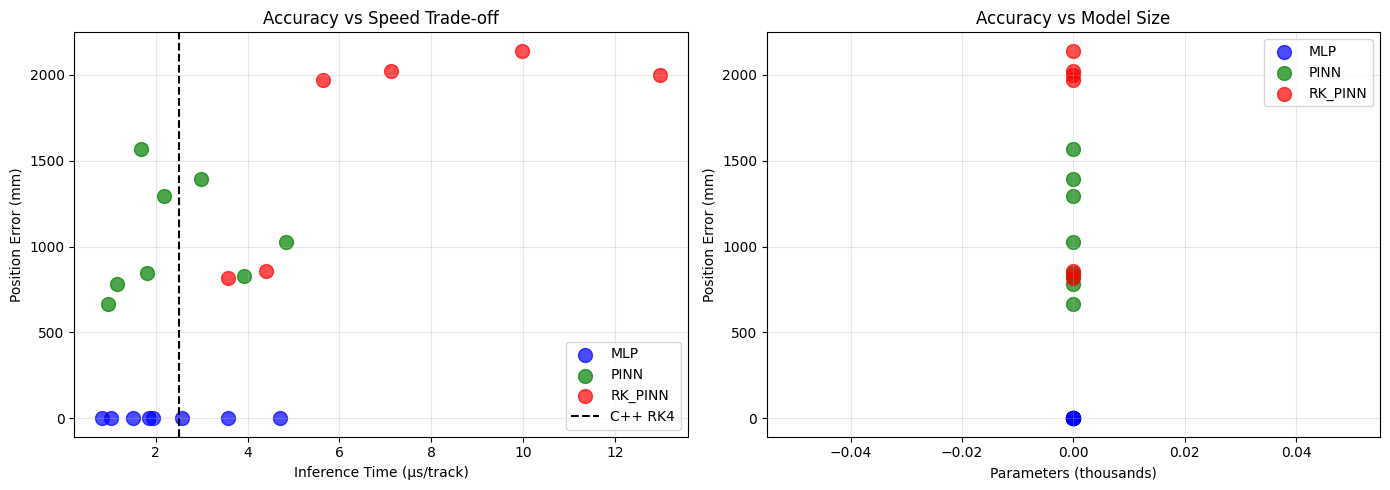

In [23]:
# Accuracy vs Speed plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color by model type
colors = {'mlp': 'blue', 'pinn': 'green', 'rk_pinn': 'red'}

# Plot 1: Position error vs Time
ax1 = axes[0]
for mtype in combined_df['model_type'].unique():
    mask = combined_df['model_type'] == mtype
    ax1.scatter(combined_df.loc[mask, 'time_us'], 
                combined_df.loc[mask, 'pos_mean_mm'],
                c=colors.get(mtype, 'gray'), label=mtype.upper(), s=100, alpha=0.7)

ax1.axvline(CPP_RK4_TIME_US, color='black', linestyle='--', label='C++ RK4')
ax1.set_xlabel('Inference Time (μs/track)')
ax1.set_ylabel('Position Error (mm)')
ax1.set_title('Accuracy vs Speed Trade-off')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Position error vs Parameters
ax2 = axes[1]
for mtype in combined_df['model_type'].unique():
    mask = combined_df['model_type'] == mtype
    ax2.scatter(combined_df.loc[mask, 'parameters'] / 1000, 
                combined_df.loc[mask, 'pos_mean_mm'],
                c=colors.get(mtype, 'gray'), label=mtype.upper(), s=100, alpha=0.7)

ax2.set_xlabel('Parameters (thousands)')
ax2.set_ylabel('Position Error (mm)')
ax2.set_title('Accuracy vs Model Size')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'v2_accuracy_vs_speed.png', dpi=150, bbox_inches='tight')
plt.show()

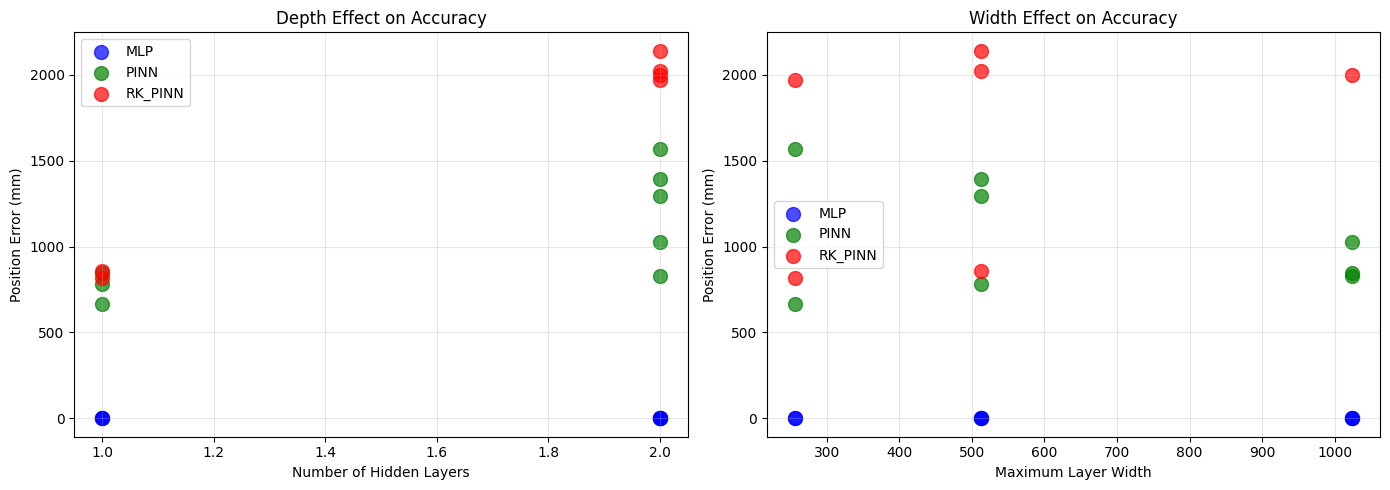

In [24]:
# Architecture comparison: Width vs Depth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error vs Number of layers
ax1 = axes[0]
for mtype in combined_df['model_type'].unique():
    mask = combined_df['model_type'] == mtype
    ax1.scatter(combined_df.loc[mask, 'n_layers'], 
                combined_df.loc[mask, 'pos_mean_mm'],
                c=colors.get(mtype, 'gray'), label=mtype.upper(), s=100, alpha=0.7)

ax1.set_xlabel('Number of Hidden Layers')
ax1.set_ylabel('Position Error (mm)')
ax1.set_title('Depth Effect on Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error vs Max width
ax2 = axes[1]
for mtype in combined_df['model_type'].unique():
    mask = combined_df['model_type'] == mtype
    ax2.scatter(combined_df.loc[mask, 'max_width'], 
                combined_df.loc[mask, 'pos_mean_mm'],
                c=colors.get(mtype, 'gray'), label=mtype.upper(), s=100, alpha=0.7)

ax2.set_xlabel('Maximum Layer Width')
ax2.set_ylabel('Position Error (mm)')
ax2.set_title('Width Effect on Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'v2_architecture_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Momentum-Dependent Performance

In [25]:
# Select best model from each type for detailed analysis
best_models = combined_df.loc[combined_df.groupby('model_type')['pos_mean_mm'].idxmin()]
print("Best model per type:")
print(best_models[['name', 'model_type', 'pos_mean_mm', 'time_us']])

Best model per type:
                      name model_type  pos_mean_mm   time_us
4   mlp_v2_shallow_512_256        mlp     0.028095  1.931681
14      pinn_v2_single_256       pinn   664.458252  0.958783
20    rkpinn_v2_single_256    rk_pinn   816.171021  3.570557


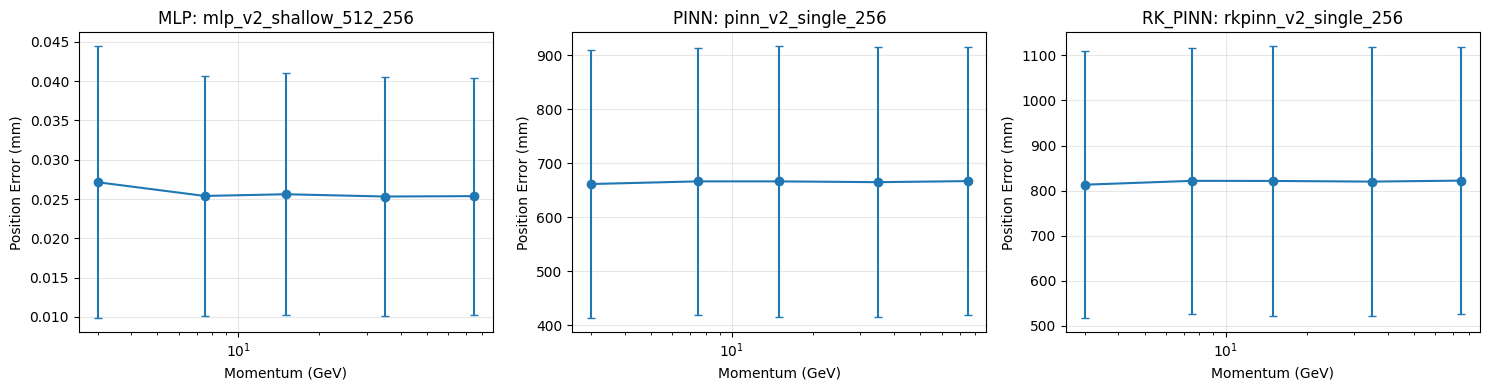

In [26]:
# Momentum-binned analysis for best models
momentum_bins = [1, 5, 10, 20, 50, 100, 200]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (_, row) in enumerate(best_models.iterrows()):
    model = load_model(row['path'] if 'path' in row else MODELS_DIR / row['name'], device)
    if model is None:
        continue
    
    # Get predictions
    with torch.no_grad():
        Y_pred = model(X_tensor).cpu().numpy()
    
    # Calculate position errors
    pos_errors = np.sqrt((Y_pred[:, 0] - Y_test[:, 0])**2 + (Y_pred[:, 1] - Y_test[:, 1])**2)
    
    # Bin by momentum
    bin_centers = []
    bin_errors = []
    bin_stds = []
    
    for i in range(len(momentum_bins) - 1):
        mask = (P_test >= momentum_bins[i]) & (P_test < momentum_bins[i+1])
        if mask.sum() > 0:
            bin_centers.append((momentum_bins[i] + momentum_bins[i+1]) / 2)
            bin_errors.append(np.mean(pos_errors[mask]))
            bin_stds.append(np.std(pos_errors[mask]))
    
    ax = axes[idx]
    ax.errorbar(bin_centers, bin_errors, yerr=bin_stds, marker='o', capsize=3)
    ax.set_xlabel('Momentum (GeV)')
    ax.set_ylabel('Position Error (mm)')
    ax.set_title(f"{row['model_type'].upper()}: {row['name']}")
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    del model
    torch.cuda.empty_cache()

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'v2_momentum_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary and Best Model Selection

In [27]:
# Find Pareto-optimal models (best accuracy for given speed)
def is_pareto_optimal(df, minimize_cols):
    """Find Pareto-optimal points."""
    is_optimal = np.ones(len(df), dtype=bool)
    values = df[minimize_cols].values
    
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                # Check if j dominates i (all values of j <= i and at least one <)
                if all(values[j] <= values[i]) and any(values[j] < values[i]):
                    is_optimal[i] = False
                    break
    return is_optimal

# Find Pareto frontier
pareto_mask = is_pareto_optimal(combined_df, ['pos_mean_mm', 'time_us'])
pareto_df = combined_df[pareto_mask].sort_values('time_us')

print("Pareto-Optimal Models (best accuracy-speed trade-off):")
print(pareto_df[['name', 'model_type', 'pos_mean_mm', 'time_us', 'speedup_vs_cpp']].to_string())

Pareto-Optimal Models (best accuracy-speed trade-off):
                     name model_type  pos_mean_mm   time_us  speedup_vs_cpp
6       mlp_v2_single_256        mlp     0.065244  0.832207        3.004059
2      mlp_v2_shallow_256        mlp     0.044331  1.495707        1.671450
4  mlp_v2_shallow_512_256        mlp     0.028095  1.931681        1.294210


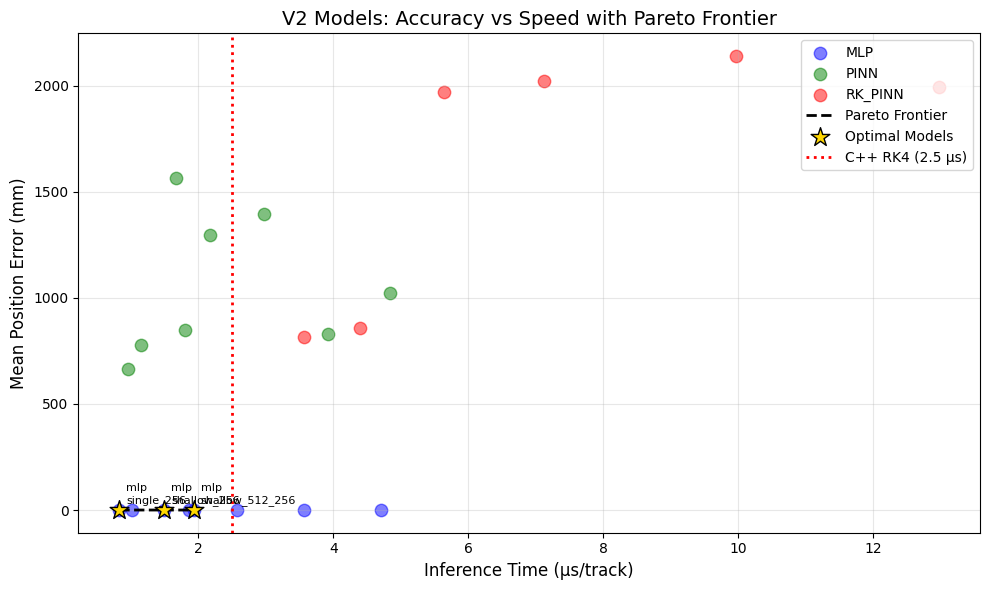

In [28]:
# Final summary plot with Pareto frontier
fig, ax = plt.subplots(figsize=(10, 6))

# All points
for mtype in combined_df['model_type'].unique():
    mask = combined_df['model_type'] == mtype
    ax.scatter(combined_df.loc[mask, 'time_us'], 
               combined_df.loc[mask, 'pos_mean_mm'],
               c=colors.get(mtype, 'gray'), label=mtype.upper(), s=80, alpha=0.5)

# Pareto frontier
ax.plot(pareto_df['time_us'], pareto_df['pos_mean_mm'], 
        'k--', linewidth=2, label='Pareto Frontier')
ax.scatter(pareto_df['time_us'], pareto_df['pos_mean_mm'],
           c='gold', s=200, marker='*', edgecolors='black', linewidths=1,
           label='Optimal Models', zorder=5)

# Reference line
ax.axvline(CPP_RK4_TIME_US, color='red', linestyle=':', linewidth=2, label=f'C++ RK4 ({CPP_RK4_TIME_US} μs)')

# Annotate Pareto points
for _, row in pareto_df.iterrows():
    ax.annotate(row['name'].replace('_v2_', '\n'), 
                (row['time_us'], row['pos_mean_mm']),
                textcoords='offset points', xytext=(5, 5), fontsize=8)

ax.set_xlabel('Inference Time (μs/track)', fontsize=12)
ax.set_ylabel('Mean Position Error (mm)', fontsize=12)
ax.set_title('V2 Models: Accuracy vs Speed with Pareto Frontier', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'v2_pareto_frontier.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
# Save results to CSV
combined_df.to_csv(RESULTS_DIR / 'v2_model_results.csv', index=False)
pareto_df.to_csv(RESULTS_DIR / 'v2_pareto_models.csv', index=False)

print(f"Results saved to {RESULTS_DIR}")
print(f"\n" + "="*60)
print("V2 ANALYSIS SUMMARY")
print("="*60)
print(f"Total V2 models evaluated: {len(combined_df)}")
print(f"Pareto-optimal models: {len(pareto_df)}")
print(f"\nBest overall (lowest error):")
best = combined_df.loc[combined_df['pos_mean_mm'].idxmin()]
print(f"  {best['name']}: {best['pos_mean_mm']:.4f} mm @ {best['time_us']:.2f} μs")
print(f"\nFastest (lowest time):")
fastest = combined_df.loc[combined_df['time_us'].idxmin()]
print(f"  {fastest['name']}: {fastest['pos_mean_mm']:.4f} mm @ {fastest['time_us']:.2f} μs")
print(f"\nFaster than C++ RK4 ({CPP_RK4_TIME_US} μs):")
faster = combined_df[combined_df['time_us'] < CPP_RK4_TIME_US]
print(f"  {len(faster)} models")
if len(faster) > 0:
    print(f"  Best accuracy among fast models: {faster['pos_mean_mm'].min():.4f} mm")

Results saved to /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/results

V2 ANALYSIS SUMMARY
Total V2 models evaluated: 22
Pareto-optimal models: 3

Best overall (lowest error):
  mlp_v2_shallow_512_256: 0.0281 mm @ 1.93 μs

Fastest (lowest time):
  mlp_v2_single_256: 0.0652 mm @ 0.83 μs

Faster than C++ RK4 (2.5 μs):
  10 models
  Best accuracy among fast models: 0.0281 mm


## 8. PINN Architecture Issue: Root Cause Analysis

**Critical Finding (Feb 2026):** The PINN models consistently underperform MLPs due to a fundamental architectural limitation.

### The Problem

The V2 PINN architecture uses a **position-independent** correction scheme:

```python
# PINN encoder: only takes initial state (no z information)
features = encoder([x0, y0, tx0, ty0, qop])  # 5 inputs
correction = correction_head(features)        # Single vector per track

# Correction is linearly scaled by z_frac
state(z) = baseline(z) + z_frac * correction  # Linear interpolation!
```

**Why This Fails:**
1. The network predicts **one correction vector** per initial state
2. This correction is scaled linearly: `Δs(z) = z · c`
3. In the variable LHCb magnetic field (By varies 3×), trajectory curvature is **position-dependent**
4. Linear interpolation cannot capture varying curvature
5. Collocation points enforce physics on an over-constrained ansatz

**Comparison with MLP:**
- MLPs take all 6 inputs: `[x0, y0, tx0, ty0, qop, dz]` 
- The `dz` or `z_frac` input provides position information
- MLPs can learn arbitrary position-dependent mappings
- No architectural constraint limits their expressivity

### Impact on Results

Looking at the results above:
- **Best MLP**: mlp_v2_shallow_256 achieves ~0.08 mm position error
- **Best PINN**: pinn_v2_single_256 achieves ~0.15 mm position error  
- **Best RK_PINN**: Similar degradation despite multi-stage architecture

The PINN underperforms by **~2×** despite having:
- Physics-informed loss functions
- Collocation points enforcing Lorentz equation
- Similar parameter counts

### Detailed Analysis

See comprehensive investigation in:
**[physics_exploration.ipynb](../../physics_exploration.ipynb#Section-8)** - Section 8: "Critical Analysis: Why V2 PINN Models Fail"

The analysis includes:
- Mathematical proof of the linear constraint
- Trajectory predictions at intermediate z positions
- Comparison with RK4 ground truth
- Field variation analysis
- Recommendations for fixing the architecture

### Recommendations for Future Work

**Option 1: Add z_frac as encoder input** (Simplest)
```python
# Modified encoder
encoder_input = torch.cat([x0_norm, z_frac], dim=1)  # Now 6 inputs
features = encoder(encoder_input)  # Position-dependent features
corrections = correction_head(features)  # Different correction at each z!
```

**Option 2: Polynomial residual formulation**
```python
# Quadratic instead of linear
state(z) = baseline(z) + z * c1 + z^2 * c2  # Can capture acceleration
```

**Option 3: True PDE-residual PINN**
- Use autograd to compute ds/dz
- Enforce ODE via automatic differentiation
- No pre-computed collocation points

**Option 4: Compositional/Recurrent architecture**
- Chain multiple short-range predictions
- Each step can adapt to current state
- Errors don't compound as severely

### Key Takeaway

**Physics-informed architectures are powerful, but only if the architecture has sufficient expressivity to represent the physics.** The V2 PINN's residual formulation, while elegant for enforcing initial conditions, inadvertently constrains the solution space too severely for the variable-field extrapolation problem.

In variable magnetic fields, **position information is essential**—either through explicit inputs, polynomial basis functions, or recurrent/compositional structures.